<a href="https://colab.research.google.com/github/billybabis/Algorithms-Course-Repo/blob/master/allmodis_awhere_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANALYZE MODIS LST & AWHERE TEMPS



## 0. Init


Initialize


In [ ]:
!pip install plotnine fsspec gcsfs

     |████████████████████████████████| 112kB 8.1MB/s 
     |████████████████████████████████| 1.3MB 14.2MB/s 
     |████████████████████████████████| 296kB 32.7MB/s 
     |████████████████████████████████| 143kB 33.5MB/s 


In [ ]:
%config InlineBackend.figure_format = 'retina'

In [ ]:
import random
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from plotnine import *
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')
custom = theme_bw() + theme(
    legend_key=element_rect(fill="None", color="None"),
    strip_background=element_rect(fill="None", color="None"),
)
theme_set(custom)

Mounted at /content/drive





**Define Helpful Functions**

In [ ]:
def load_data():
  df = pd.read_parquet('/content/drive/My Drive/atlas/allmodis_awhere_temps.parquet.gz')
  df['date'] = pd.to_datetime(df['date'])
  df['year'] = df['date'].dt.year
  return df

def _calc_stats(d, y_var, y_hat_var):
    d = d.loc[(d[y_var].notnull() & d[y_hat_var].notnull())]
    r2 = linregress(d[y_hat], d[y]).rvalue ** 2
    n = d.shape[0]
    rmse = np.sqrt(np.mean((d[y_hat] - d[y]) ** 2))
    pct_dev = abs((d[y_hat] - d[y]) / d[y]) * 100
    mape = np.nanmean(pct_dev[np.isfinite(pct_dev)])
    mdape = np.median(pct_dev)
    pct_lte_10 = np.sum(pct_dev < 10) / n * 100
    return r2, mape, mdape, pct_lte_10, rmse, n

In [ ]:
def _regress_SLRM(d, yvar, xvars):
    d = d.loc[(d[yvar].notnull())]
    for xvar in xvars:
      d = d.loc[(d[xvar].notnull())]
    n = d.shape[0]
    if n == 0:
      return None
    m = linregress(d[xvars], d[yvar])
    slope = m.slope
    intercept = m.intercept
    r2 = m.rvalue ** 2
    return pd.DataFrame({'slope': slope, 'intercept': intercept, 'r2': r2, 'n': n}, index=[0])

def _regress(d, yvar, xvars):
  d = d.loc[(d[yvar].notnull())]
  for xvar in xvars:
    d = d.loc[(d[xvar].notnull())]
  n = d.shape[0]
  if n == 0:
    return None
  X, y = d[xvars], d[yvar]
  lm = linear_model.LinearRegression()
  model = lm.fit(X, y)
  y_pred = model.predict(X)
  r2 = r2_score(y, y_pred)
  #r2 = model.score(X, y)
  coeffs = model.coef_
  output_dict = {'intercept': model.intercept_, 'r2': r2, 'n': n}
  for i in range(len(xvars)):
    output_dict["coef_{}".format(xvars[i])] = coeffs[i]
  return pd.DataFrame(output_dict, index=[0])


def _regress_train(d, yvar, xvars):
  d = d.loc[(d[yvar].notnull())]
  for xvar in xvars:
    d = d.loc[(d[xvar].notnull())]
  n = d.shape[0]
  if n == 0:
    return None
  d['rand'] = np.random.randint(0, 100, d.shape[0])
  d_train = d.loc[(d['rand']<70)]
  d_test = d.loc[(d['rand']>=70)]
  X_train, X_test = [dset[xvars] for dset in [d_train, d_test]]
  y_train, y_test = [dset[yvar] for dset in [d_train, d_test]]
  lm = linear_model.LinearRegression()
  model = LinearRegression().fit(X_train, y_train)
  r2_train = model.score(X_train, y_train)
  r2_test = model.score(X_test, y_test)
  coeffs = model.coef_
  output_dict = {'intercept': model.intercept_, 'r2_test': r2_test, 'r2_train': r2_train, 'n': n}
  for i in range(len(xvars)):
    output_dict["coef_{}".format(xvars[i])] = coeffs[i]
  return pd.DataFrame(output_dict, index=[0])

def _add_grid_info(d, grid_id, lat, lng):
  d["grid_id"] = grid_id
  d["latitude"] = lat
  d["longitude"] = lng
  return d

def add_polynomial_term(d, xvar, deg):
  newcol = "{}{}".format(xvar,str(deg))
  d[newcol] = d[xvar] ** deg
  return d

**Generate Init Point Coefficients**

In [ ]:
og_df = load_data()
og_df['grid_id'] = og_df.groupby(['latitude','longitude']).ngroup()

def count_non_null_rows(g, xvars):
  g["num_terra_days"] = min(g[xvars[0]].count(), g[xvars[2]].count())
  g["num_aqua_days"] = min(g[xvars[1]].count(), g[xvars[3]].count())
  return g
def min_nonnull_rows(g):
  g["min_terra_days"] = g["num_terra_days"].min()
  g["min_aqua_days"] = g["num_aqua_days"].min()
  return g
def filter_equatorial_nullpoints(d, xvars):
  d = d.groupby(['grid_id', 'year']).apply(lambda g: count_non_null_rows(g, xvars)).reset_index(drop=True)
  d = d.groupby(['grid_id']).apply(lambda g: min_nonnull_rows(g)).reset_index(drop=True)
  return d.loc[d["min_terra_days"]>6].loc[d["min_aqua_days"]>6]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 2 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


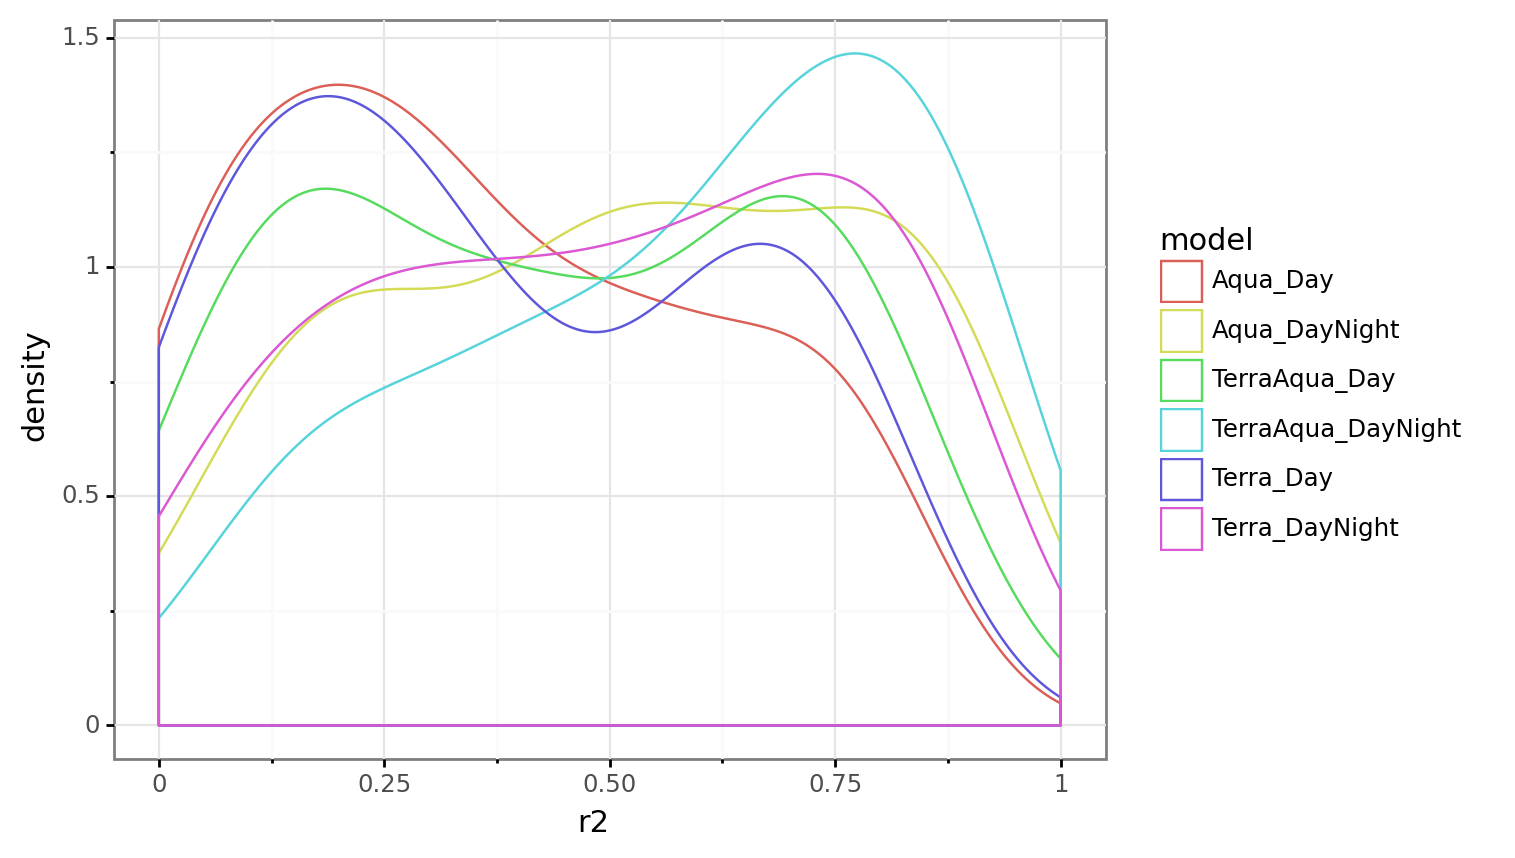

<ggplot: (8734818608821)>

In [ ]:
df = og_df.copy()
#print(df.columns)

xvars = ['LST_Terra_LST_Day_1km', 'LST_Aqua_LST_Day_1km', 'LST_Terra_LST_Night_1km', 'LST_Aqua_LST_Night_1km']
yvar = "awhere_max_temps"


def reg(d, yvar, xvars, grid_id, label):
  model = _regress(d, yvar, xvars)
  model = _add_grid_info(model, grid_id, d.iloc[0]["latitude"], d.iloc[0]["longitude"])
  model["model"] = label
  return model

points_df = pd.DataFrame(columns=["grid_id", "model", "latitude", "longitude", "intercept", "r2", "n"]+["coef_"+xvar for xvar in xvars])
for i in range(115):
  d = df.loc[df["grid_id"]==i]
  model = reg(d, yvar, xvars[:1], i, "Terra_Day")
  points_df = points_df.append(model.iloc[0])
  model2 = reg(d, yvar, xvars[:2], i, "TerraAqua_Day")
  points_df = points_df.append(model2.iloc[0])
  model3 = reg(d, yvar, xvars, i, "TerraAqua_DayNight")
  points_df = points_df.append(model3.iloc[0])
  model4 = reg(d, yvar, [xvars[0], xvars[2]], i, "Terra_DayNight")
  points_df = points_df.append(model4.iloc[0])
  model5 = reg(d, yvar, [xvars[1], xvars[3]], i, "Aqua_DayNight")
  points_df = points_df.append(model5.iloc[0])
  model6 = reg(d, yvar, [xvars[1]], i, "Aqua_Day")
  points_df = points_df.append(model6.iloc[0])

ggplot(points_df, aes('r2', group="model", colour="model")) + geom_density() 
#"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


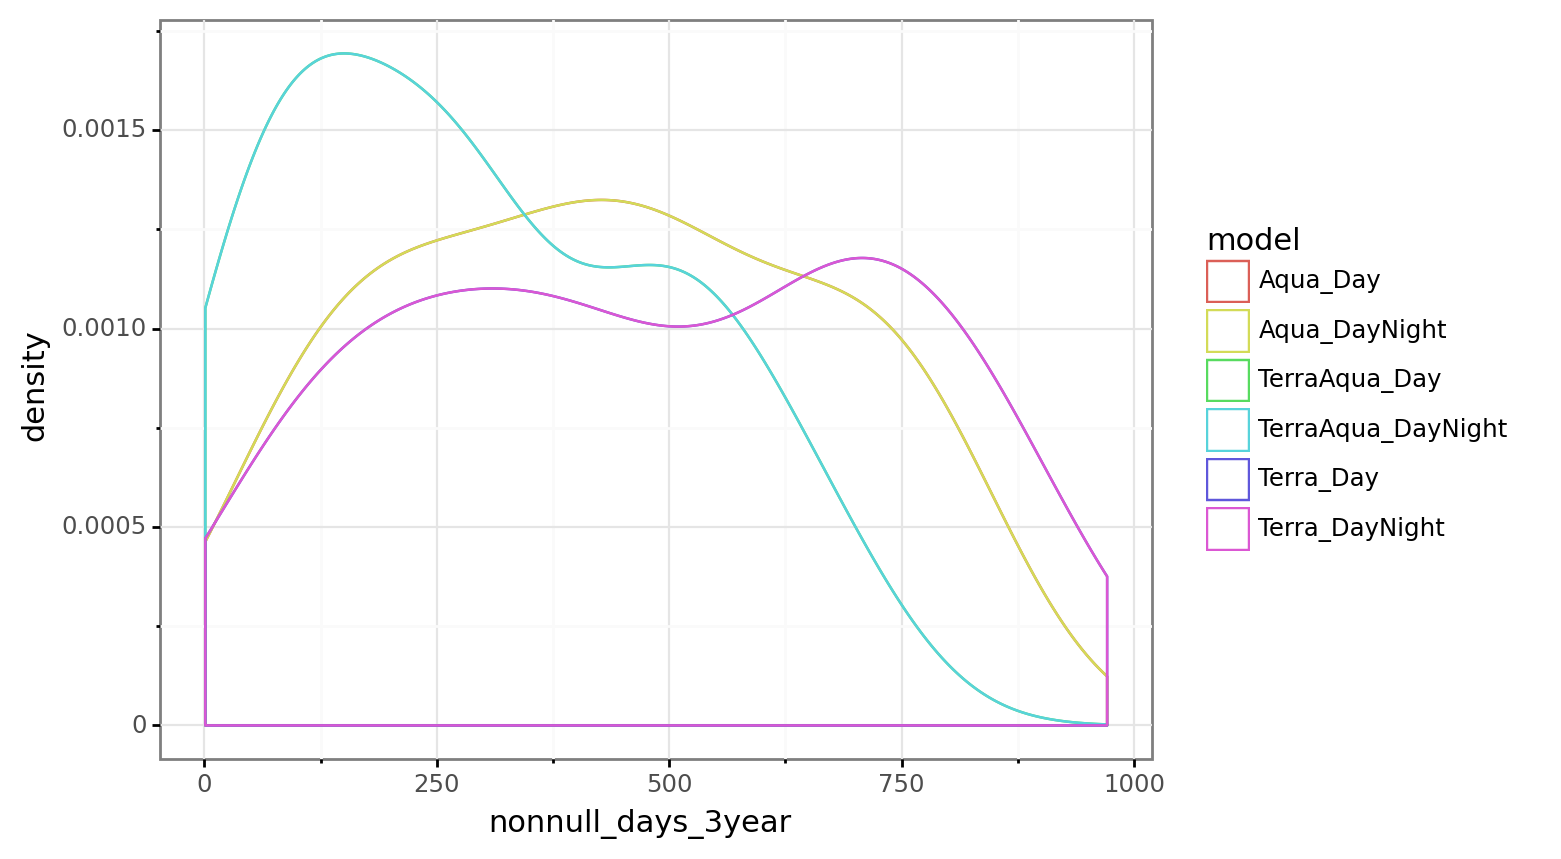

<ggplot: (8734825569257)>

In [ ]:
df1 = points_df[["model", "n", "grid_id"]]
df1["nonnull_days_3year"] = df1["n"].astype(float)
#model_names = df1["model"].unique()
#d1 = df1.loc[df1["model"]!=model_names[3]]

ggplot(df1, aes('nonnull_days_3year', group="model", colour="model")) + geom_density() 


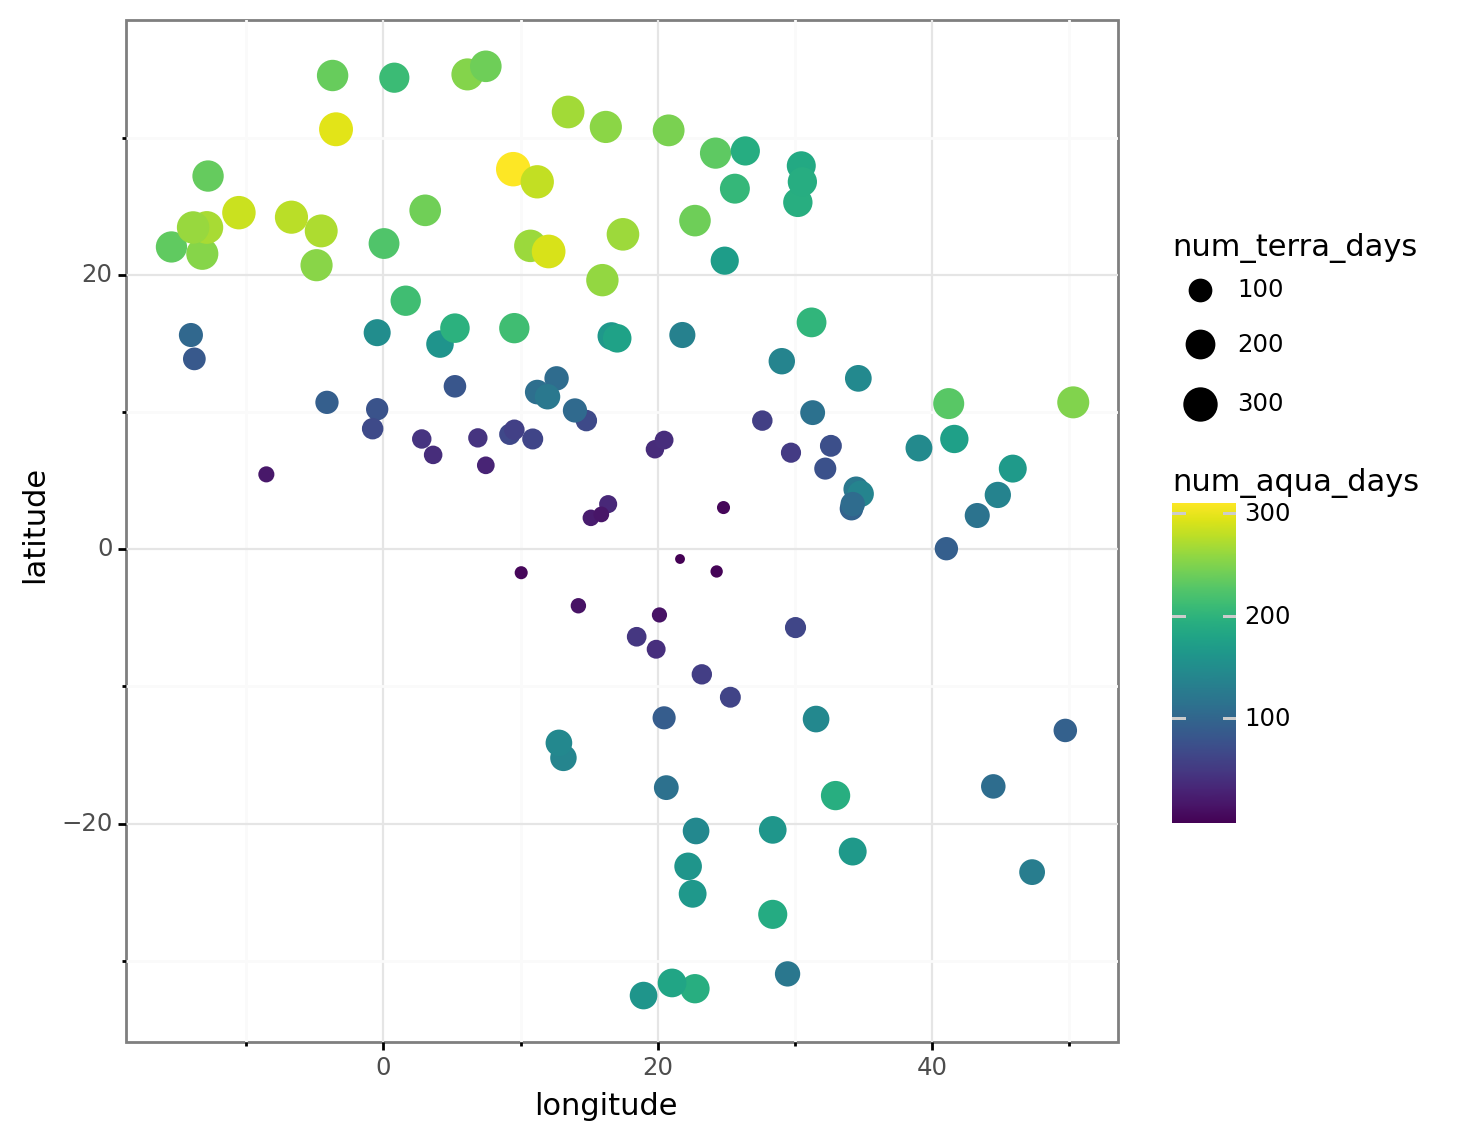

<ggplot: (8734804581041)>

In [ ]:
xvars = ['LST_Terra_LST_Day_1km', 'LST_Aqua_LST_Day_1km', 'LST_Terra_LST_Night_1km', 'LST_Aqua_LST_Night_1km']
def count_non_null_rows(g):
  g["num_terra_days"] = g[xvars[1]].count()
  g["num_aqua_days"] = g[xvars[1]].count()
  return g
d0 = df.groupby(['grid_id', 'year']).apply(lambda g: count_non_null_rows(g)).reset_index(drop=True)
d0 = d0.drop_duplicates('grid_id')
ggplot(d0, aes('longitude', 'latitude', size='num_terra_days', color="num_aqua_days")) + geom_point() + coord_fixed()

## 1. Harmonic Smoothing for Missing Days

In [ ]:
df_harm = og_df.copy()
df_harm['t'] = df_harm.apply(lambda row: row['date'] - datetime(row['year'], 1, 1), axis=1) #gives DOY
df_harm['t'] = df_harm.apply(lambda row: row['t'] /  (datetime(row['year']+1, 1, 1) - datetime(row['year'], 1, 1)), axis=1) #DOY normalized to 0-1 range


In [ ]:
print(df_harm["grid_id"].unique().size)
df_harm = filter_equatorial_nullpoints(df_harm, xvars)
print(df_harm["grid_id"].unique().size)

115
112


In [ ]:
nharmonics = 2
omega = 0.0027

def fourier(t, *coeffs):
  lst_fit = coeffs[0] + coeffs[1] * t
  for n in range(nharmonics):
    timerad = t * 2 * (n+1) * np.pi * omega
    lst_fit += coeffs[2 + n*2] * np.cos(timerad) + coeffs[3 + n*2] * np.sin(timerad)
  return lst_fit

def fit_ts(d0, xvars):
  for modis_set in xvars:
    d = d0[~d0[modis_set].isnull()]
    if d.shape[0]==0:
      print(d0[["grid_id", "latitude", "longitude"]].iloc[0])
      return None
    else:
      popt, pcov = curve_fit(fourier, d['t'],
                            d[modis_set], [1, 1] + [1, 1]*nharmonics)
      d0[modis_set+'_harmfit'] = fourier(d0['t'], *popt)
  return d0

xvars = ['LST_Terra_LST_Day_1km', 'LST_Aqua_LST_Day_1km', 'LST_Terra_LST_Night_1km', 'LST_Aqua_LST_Night_1km']
df_harm = df_harm.groupby(['grid_id', 'year']).apply(lambda g: fit_ts(g, xvars)).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
#df_harm[["LST_Terra_LST_Day_1km", "LST_Terra_LST_Day_1km_harmfit", "latitude", "longitude"]].head(10)

61 10.21 -0.4599999999999999


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 283 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


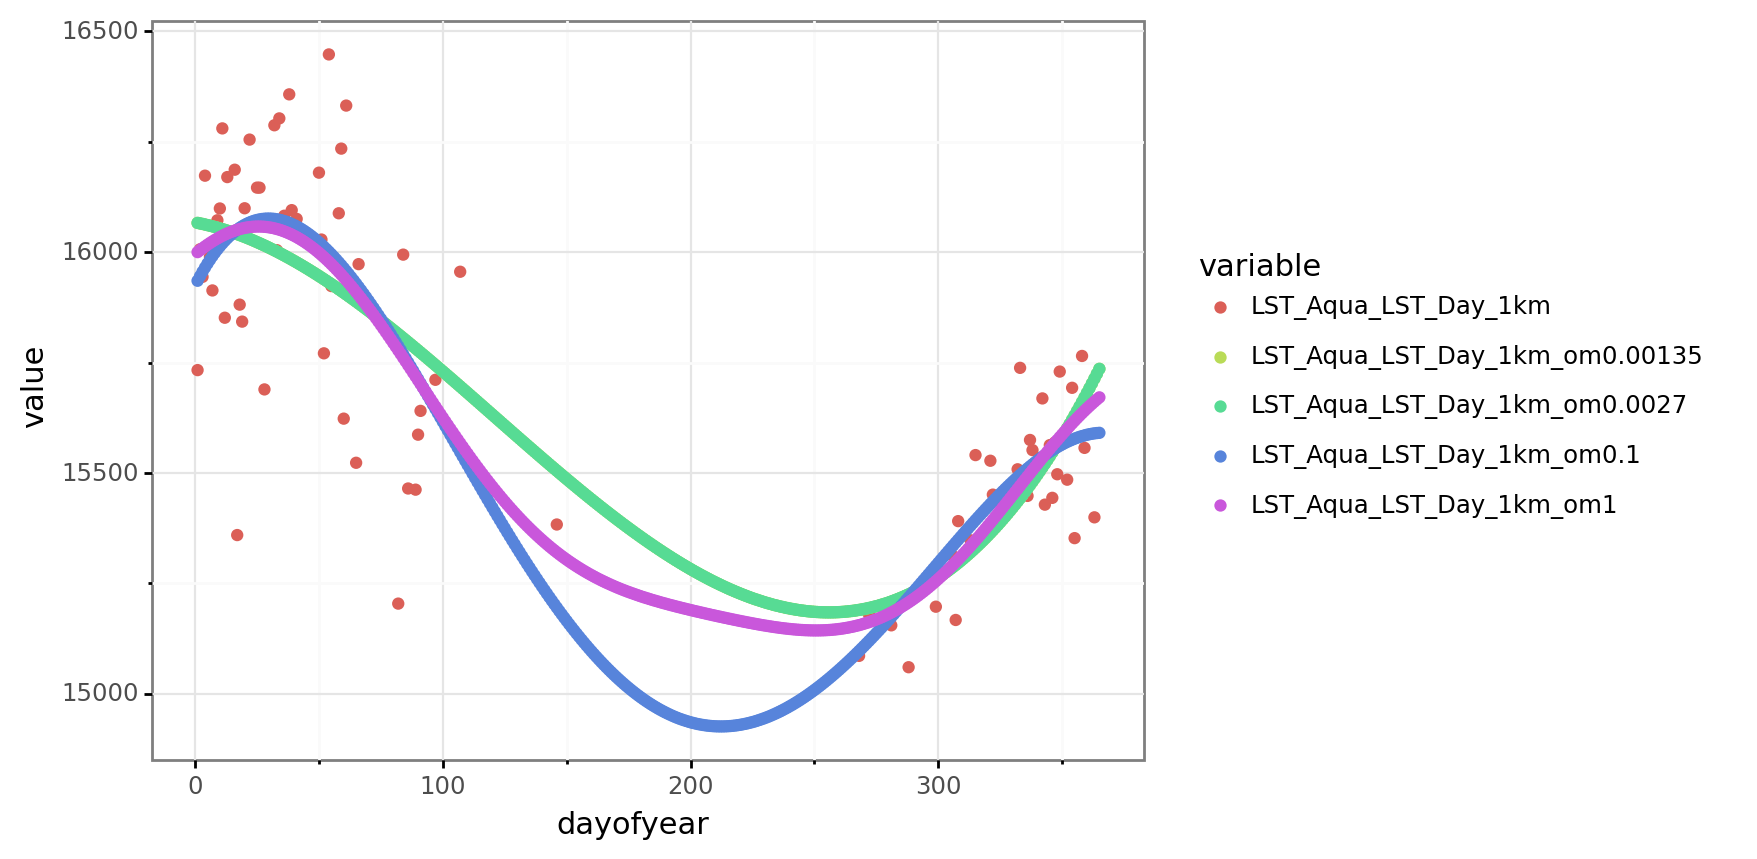

<ggplot: (8734792294485)>

In [128]:
## test different values of omega
df_harm_test = df_harm.copy()
df_harm_test["dayofyear"] = df_harm_test["date"].dt.dayofyear

#grid_id = df_harm_test['grid_id'].unique()[random.randint(1,112)]
grid_id = 61
df_harm_test_3y = df_harm_test.loc[df_harm_test["grid_id"]==grid_id]
row =  df_harm_test_3y.iloc[0]
year0, lat, lng = row["year"], row["latitude"], row["longitude"]
print(grid_id, lat, lng)
df_harm_test_1y = df_harm_test_3y[(df_harm_test_3y["year"]==year0)]

xvars = ['LST_Terra_LST_Day_1km', 'LST_Aqua_LST_Day_1km', 'LST_Terra_LST_Night_1km', 'LST_Aqua_LST_Night_1km']
band = xvars[1]

nharmonics = 2
omega_values = [0.00135, 0.0027, 0.1, 1]
for omega in omega_values: 
  def fourier(t, *coeffs):
    lst_fit = coeffs[0] + coeffs[1] * t
    for n in range(nharmonics):
      timerad = t * 2 * (n+1) * np.pi * omega
      lst_fit += coeffs[2 + n*2] * np.cos(timerad) + coeffs[3 + n*2] * np.sin(timerad)
    return lst_fit

  def fit_ts(d0, modis_set):
    d = d0[~d0[modis_set].isnull()]
    if d.shape[0]==0:
      print(d0[["grid_id", "latitude", "longitude"]].iloc[0])
      return None
    else:
      popt, pcov = curve_fit(fourier, d['t'],
                            d[modis_set], [1, 1] + [1, 1]*nharmonics)
      d0[modis_set+'_om'+str(omega)] = fourier(d0['t'], *popt)
      return d0
    
  df_harm_test_1y = df_harm_test_1y.groupby(['grid_id']).apply(lambda g: fit_ts(g, band)).reset_index(drop=True)

columns = [band] + [band+"_om"+str(omega) for omega in omega_values]
df_harm_test_1y = pd.melt(df_harm_test_1y, id_vars=['grid_id', "latitude", "longitude", "dayofyear"], value_vars=columns)
ggplot(df_harm_test_1y, aes(x='dayofyear', y='value', group = "variable", colour = "variable")) + geom_point() 
#"""

## 2. Regressions


In [ ]:
def _clear_nulls(d, yvar, xvars):
  d = d.loc[(d[yvar].notnull())]
  for xvar in xvars:
    d = d.loc[(d[xvar].notnull())]
  n = d.shape[0]
  if n == 0:
    return None
  return d

def _filter_leap_years(d):
  return d[d["dayofyear"] != 366]

def _divide_dset(d, num_train_years):
  d = _filter_leap_years(d)
  years = d['year'].unique()
  d_test = d[(d["year"]== years[2])]
  d_train = d[(d["year"]== years[0])]
  if num_train_years == 2:
    d_train = d_train.append(d[(d["year"]== years[1])])
  return d_train, d_test

def _regress_traintest(d_train, d_test, yvar, xvars):
  n = d_train.shape[0]
  X_train, X_test = [d[xvars] for d in [d_train, d_test]]
  y_train, y_test = [d[yvar] for d in [d_train, d_test]]
  lm = linear_model.LinearRegression()
  model = lm.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  coeffs = model.coef_
  r2_test = r2_score(y_test, y_pred)
  r2_train = r2_score(y_train, model.predict(X_train))
  output_dict = {'intercept': model.intercept_, 'r2_test': r2_test, 'r2_train': r2_train, 'n': n}
  for i in range(len(xvars)):
    output_dict["coef_{}".format(xvars[i])] = coeffs[i]
  return pd.DataFrame(output_dict, index=[0])

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


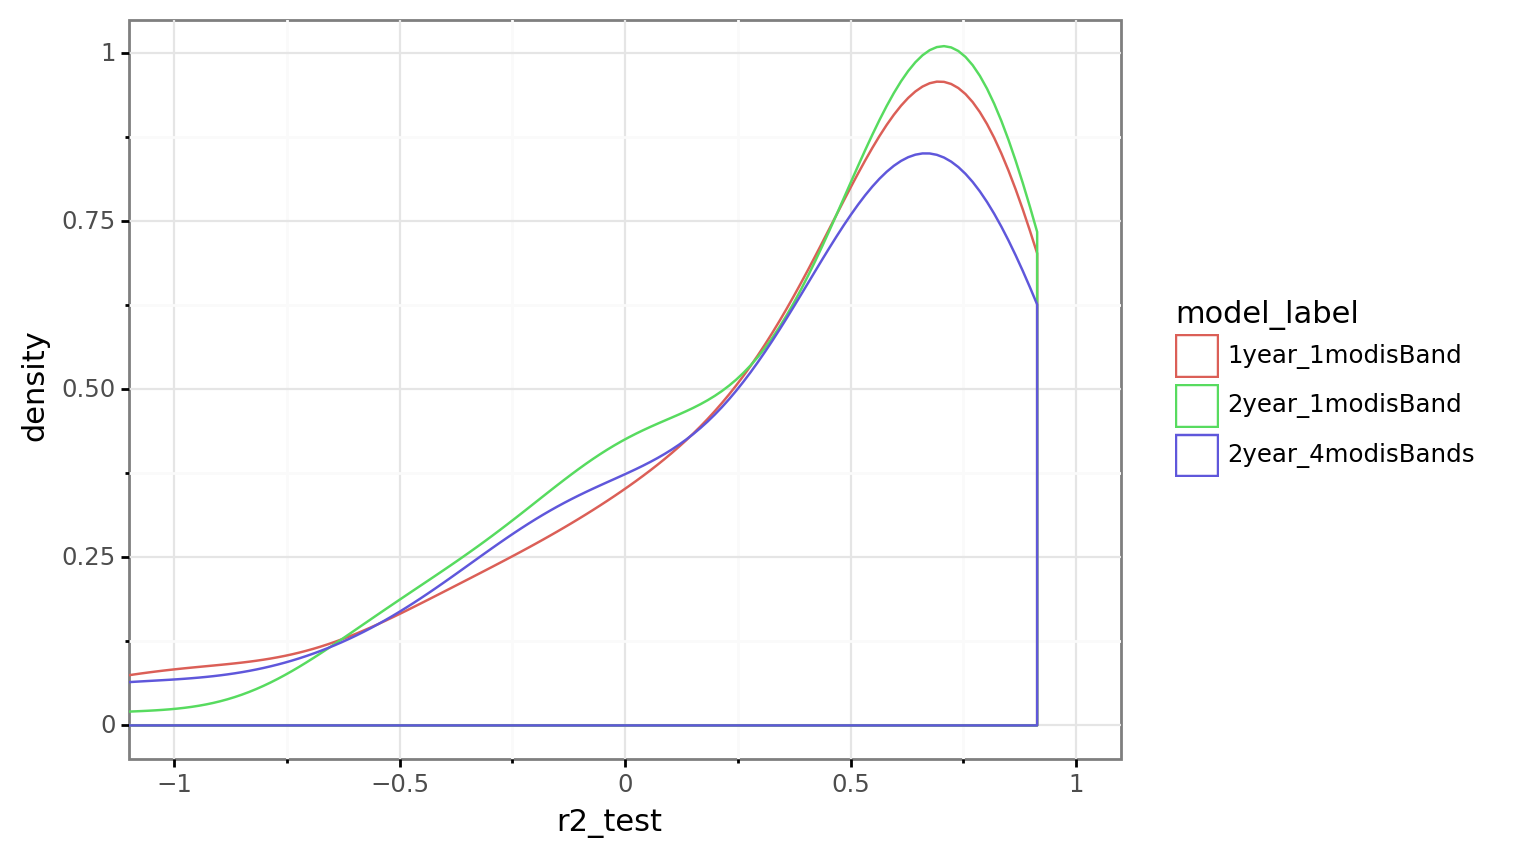

<ggplot: (8734804719877)>

In [ ]:
d1 = df_harm.copy()
d1["dayofyear"] = d1["date"].dt.dayofyear

xvars = ['LST_Aqua_LST_Day_1km_harmfit', 'LST_Terra_LST_Day_1km_harmfit', 'LST_Terra_LST_Night_1km_harmfit', 'LST_Aqua_LST_Night_1km_harmfit']
yvar = "awhere_min_temps"
cols = ["grid_id", "latitude", "longitude", "intercept", "r2_test", "r_train", "n"] + ["coef_"+xvar for xvar in xvars]
point_regs_2y = pd.DataFrame(columns=cols)
point_regs_1y = pd.DataFrame(columns=cols)
point_regs_2y_1var = pd.DataFrame(columns=cols)
point_regs_1y_1var = pd.DataFrame(columns=cols)

def _grid_regression(d, yvar, xvars, num_train_years, grid_id, lat, lng):
  d_train, d_test = _divide_dset(d, num_train_years)
  point_reg = _regress_traintest(d_train, d_test, yvar, xvars)
  return _add_grid_info(point_reg, grid_id, lat, lng)
  
for grid_id in d1['grid_id'].unique():
  daily_obs_3year = d1.loc[d1["grid_id"]==grid_id]
  daily_obs_3year = _clear_nulls(daily_obs_3year, yvar, xvars)
  lat = daily_obs_3year.iloc[0]["latitude"]
  lng = daily_obs_3year.iloc[0]["longitude"]
  ## 4 modis vars in x
  point_reg_1y = _grid_regression(daily_obs_3year, yvar, xvars, 1, grid_id, lat, lng)
  point_regs_1y = point_regs_1y.append(point_reg_1y)
  point_reg_2y = _grid_regression(daily_obs_3year, yvar, xvars, 2, grid_id, lat, lng)
  point_regs_2y = point_regs_2y.append(point_reg_2y)
  ## 1 modis var in x
  point_reg_1y_1var = _grid_regression(daily_obs_3year, yvar, [xvars[2]], 1, grid_id, lat, lng)
  point_regs_1y_1var = point_regs_1y_1var.append(point_reg_1y_1var)
  point_reg_2y_1var = _grid_regression(daily_obs_3year, yvar, [xvars[2]], 2, grid_id, lat, lng)
  point_regs_2y_1var = point_regs_2y_1var.append(point_reg_2y_1var)

point_regs_1y["model_label"] = "1year_4modisBands"
point_regs_2y["model_label"] = "2year_4modisBands"
point_regs_1y_1var["model_label"] = "1year_1modisBand"
point_regs_2y_1var["model_label"] = "2year_1modisBand"
point_regs = point_regs_2y.append(point_regs_1y_1var).append(point_regs_2y_1var)
ggplot(point_regs, aes('r2_test', group = "model_label", colour = "model_label")) + geom_density() + coord_cartesian(xlim=(-1, 1), ylim=(0, 1))

# Repeat Experiments: Random Days

## Test Proper Specification

In [ ]:
def divide_dset_by_random_days(d, pct_train):
  d = d[d["dayofyear"] != 366]
  train_days = random.sample(range(1, 366), int(pct_train*365))
  d_train = d[d["dayofyear"].isin(train_days)]
  d_test = d[~d["dayofyear"].isin(train_days)]
  return d_train, d_test

def _clear_nulls(d, yvar, xvars):
  d = d.loc[(d[yvar].notnull())]
  for xvar in xvars:
    d = d.loc[(d[xvar].notnull())]
  n = d.shape[0]
  if n == 0:
    return None
  return d

def _regress_traintest(d_train, d_test, yvar, xvars):
  n = d_train.shape[0]
  X_train, X_test = [d[xvars] for d in [d_train, d_test]]
  y_train, y_test = [d[yvar] for d in [d_train, d_test]]
  lm = linear_model.LinearRegression()
  model = lm.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  coeffs = model.coef_
  r2_test = r2_score(y_test, y_pred)
  r2_train = r2_score(y_train, model.predict(X_train))
  output_dict = {'intercept': model.intercept_, 'r2_test': r2_test, 'r2_train': r2_train, 'n': n}
  for i in range(len(xvars)):
    output_dict["coef_{}".format(xvars[i])] = coeffs[i]
  return pd.DataFrame(output_dict, index=[0])

def _reg(d, yvar, xvars, grid_id):
  lat, lng = d.iloc[0]["latitude"], d.iloc[0]["longitude"]
  d_train, d_test = divide_dset_by_random_days(d, 0.7)
  point_reg = _regress_traintest(d_train, d_test, yvar, xvars)
  return _add_grid_info(point_reg, grid_id, lat, lng)


35
40
24
32


/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 10 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


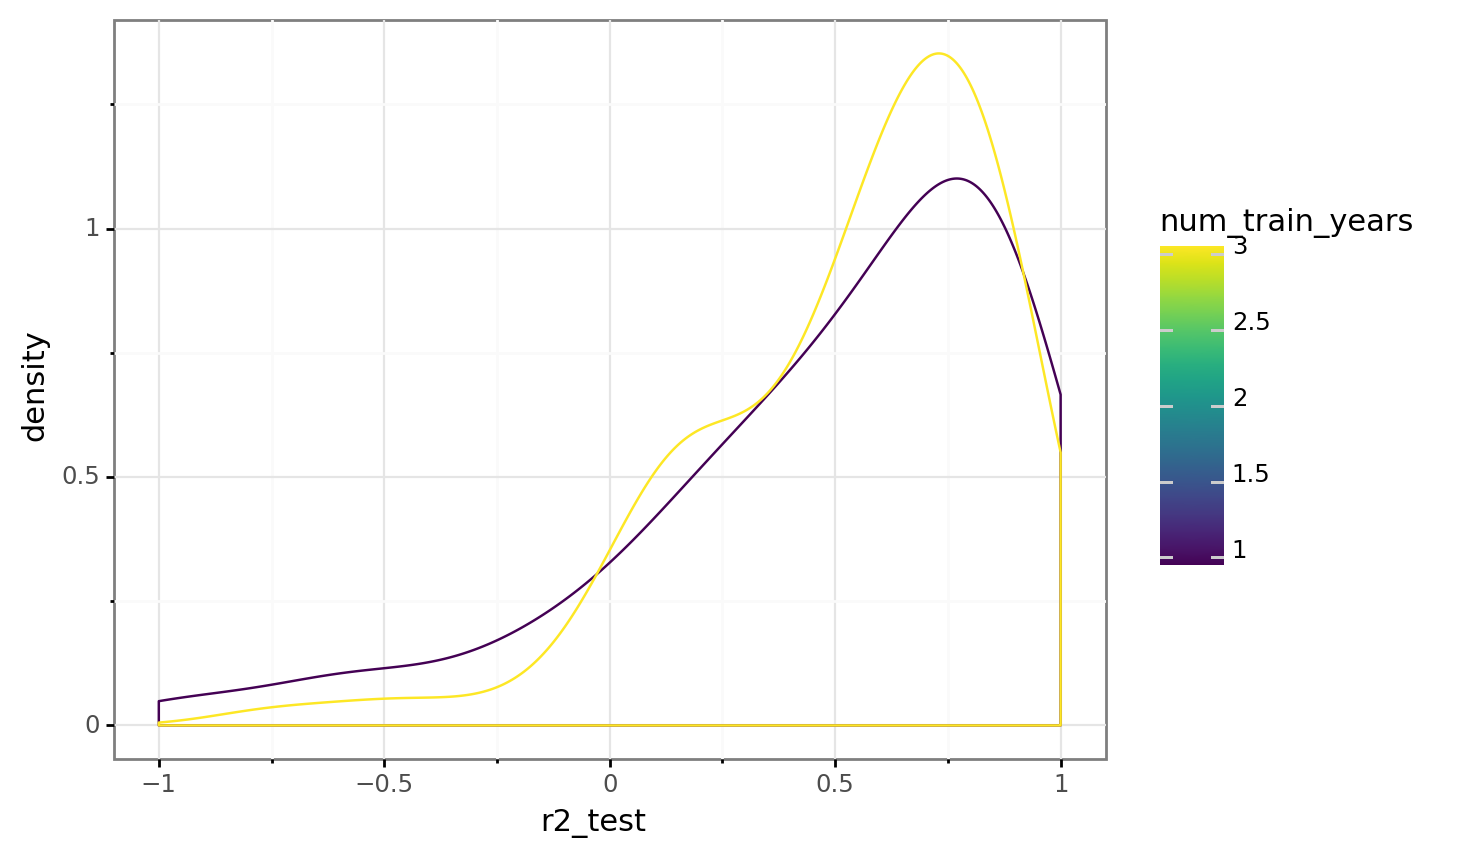

<ggplot: (8734778701725)>

In [76]:
## 1 year vs 3 years
d = df_harm.copy()
d["dayofyear"] = d["date"].dt.dayofyear

xvars = ['LST_Terra_LST_Day_1km', 'LST_Aqua_LST_Day_1km', 'LST_Terra_LST_Night_1km', 'LST_Aqua_LST_Night_1km']
yvar = "awhere_max_temps"

cols = ["grid_id", "latitude", "longitude", "intercept", "r2_test", "r_train", "n"] + ["coef_"+xvar for xvar in xvars]
point_regs_1y = pd.DataFrame(columns=cols)
point_regs_3y = pd.DataFrame(columns=cols)

for grid_id in d['grid_id'].unique():
  daily_obs_3year = d[(d["grid_id"]==grid_id)]
  daily_obs_3year = _clear_nulls(daily_obs_3year, yvar, xvars)
  year0 = daily_obs_3year.iloc[0]["year"]
  daily_obs_1year = daily_obs_3year[(daily_obs_3year["year"]==year0)]
  if daily_obs_1year.shape[0]<6 or daily_obs_1year.shape[1]<6:
    print(grid_id)
  else:
    point_reg_3y = _reg(daily_obs_3year, yvar, xvars, grid_id)
    point_regs_3y = point_regs_3y.append(point_reg_3y)
    point_reg_1y = _reg(daily_obs_1year, yvar, xvars, grid_id)
    point_regs_1y = point_regs_1y.append(point_reg_1y)

point_regs_1y["num_train_years"] = 1
point_regs_3y["num_train_years"] = 3
point_regs = point_regs_1y.append(point_regs_3y)
ggplot(point_regs, aes('r2_test', group="num_train_years", colour="num_train_years")) + geom_density() + scale_x_continuous(limits=(-1, 1))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 10 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


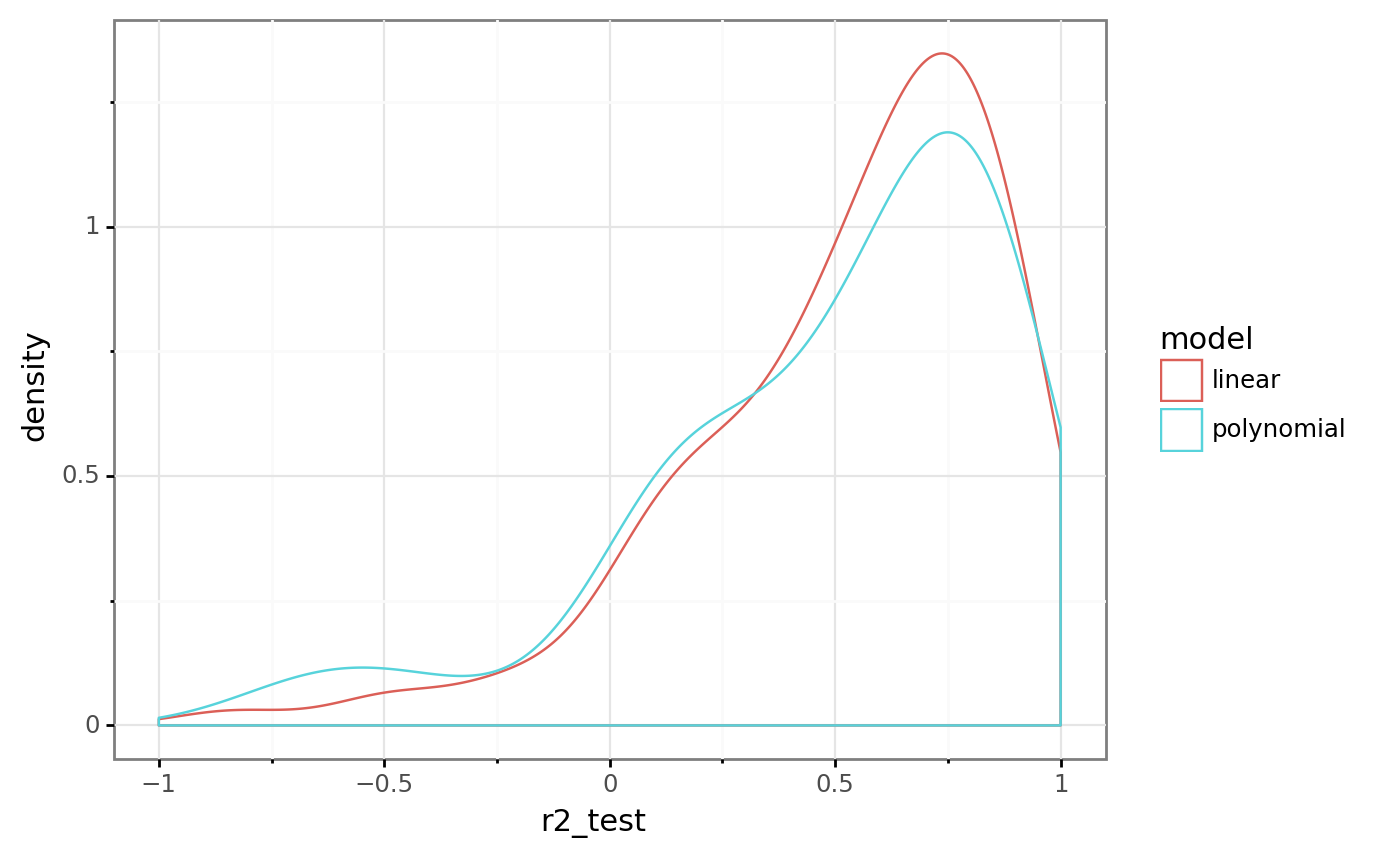

<ggplot: (8734779437457)>

In [88]:
## Polynomial Regression
df_poly = df_harm.copy()
df_poly["dayofyear"] = df_poly["date"].dt.dayofyear

xvars = ['LST_Terra_LST_Day_1km', 'LST_Aqua_LST_Day_1km', 'LST_Terra_LST_Night_1km', 'LST_Aqua_LST_Night_1km']
yvar = "awhere_max_temps"
def add_polynomial_term(d, xvar, deg):
  newcol = "{}{}".format(xvar,str(deg))
  d[newcol] = d[xvar] ** deg
  return d
xvars_poly = []
for xvar in xvars:
  df_poly = add_polynomial_term(df_poly, xvar, 2)
  xvars_poly += [xvar, xvar+"2"]

cols = ["grid_id", "latitude", "longitude", "model", "intercept", "r2_test", "r_train", "n"] + ["coef_"+xvar for xvar in xvars]
point_regs = pd.DataFrame(columns=cols)
for grid_id in df_poly['grid_id'].unique():
  daily_obs_3year = df_poly[(df_poly["grid_id"]==grid_id)]
  year0 = daily_obs_3year.iloc[0]["year"]
  lat = daily_obs_3year.iloc[0]["latitude"]
  lng = daily_obs_3year.iloc[0]["longitude"]
  daily_obs_3year = _clear_nulls(daily_obs_3year, yvar, xvars)
  if daily_obs_3year.shape[0]<6 or daily_obs_3year.shape[1]<6:
    print(grid_id)
  else:
    point_reg = _reg(daily_obs_3year, yvar, xvars, grid_id)
    point_reg["model"] = "linear"
    point_regs = point_regs.append(point_reg)
    point_reg = _reg(daily_obs_3year, yvar, xvars_poly, grid_id)
    point_reg["model"] = "polynomial"
    point_regs = point_regs.append(point_reg)

ggplot(point_regs, aes('r2_test', group='model', colour='model')) + geom_density() + scale_x_continuous(limits=(-1, 1))